In [1]:
from scipy.stats import kurtosis
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
my_random_state = 318
import time
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score,plot_confusion_matrix, confusion_matrix

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score
from sklearn.mixture import GaussianMixture

from sklearn.decomposition import PCA, FastICA, NMF
from sklearn.random_projection import GaussianRandomProjection

clusterings = ['k-means','EM']
dimReductions = ['PCA','ICA', 'RP', 'NMF']

In [2]:
###### E-coli 
### http://archive.ics.uci.edu/ml/datasets/Ecoli
# data = pd.read_csv('datafiles/ecoli.csv')))  # very unbalanced
# class_names = np.array(['cp', 'im', 'imL', 'imS', 'imU','om','omL','pp'])
data = pd.read_csv('datafiles/ecoli-balance.csv') # balanced: merged sub-species of E-coli
class_names = np.array(['cp', 'im', 'om','pp'])
y_data = data.Y
x_data = data.loc[:,'X1':'X7']

In [3]:
one_hot = OneHotEncoder()

y_data_hot = one_hot.fit_transform(y_data.values.reshape(-1, 1)).todense()
# y_test_hot = one_hot.transform(y_test.reshape(-1, 1)).todense()
y_data_hot.shape

(336, 4)

In [4]:

le = LabelEncoder()
le.fit(y_data.values.tolist())
y_data_le = le.transform(y_data)
y_data_le.shape

(336,)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data_le, train_size=0.7, random_state=my_random_state, shuffle=True)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(235, 7) (101, 7) (235,) (101,)


In [6]:
# one_hot.inverse_transform(y_train)

# 2.1 Dimensionality Reduction: ICA

In [7]:
DR = FastICA(#n_components = 2, 
             random_state = my_random_state)

tic = time.perf_counter() 
DR.fit(x_train)
toc = time.perf_counter() 
# train_time[0] = toc-tic
print(f"training time {toc - tic} seconds")
print()

training time 0.03050740000071528 seconds



In [8]:
from scipy.stats import kurtosis
kurtosis(DR.components_)

array([ 0.40492122, -0.40293858,  1.75101187,  0.77531391,  1.18287004,
        0.50494164,  0.79919885])

In [9]:
DR.mean_

array([0.50829787, 0.50685106, 0.49770213, 0.50212766, 0.50017021,
       0.50965957, 0.50310638])

training time 0.0015032999999675667 seconds
[-1.35495367]

training time 0.007865100000344682 seconds
[-0.64032003 -0.98220103]

training time 0.0028161000009276904 seconds
[-0.6601146  -0.94040937 -0.36541253]

training time 0.0028532999986055074 seconds
[-0.25500079  0.13530335 -1.52873337  0.80863918]

training time 0.0031739000005472917 seconds
[-1.57608937 -0.45355882  1.0654865   0.10673291 -0.78785128]

training time 0.0036682999998447485 seconds
[ 0.78752816 -1.0639787  -0.24131195  1.96795235  0.67712937  0.22448198]

training time 0.004361700001027202 seconds
[-0.64592938  0.28533055  2.16660772 -0.6970152   0.40789027  0.49594223
  0.45953698]



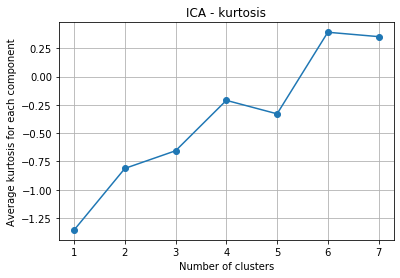

In [11]:
# Kurtosis
numfeatures = x_train.shape[1]
kurtosis_all = []
for i in range(1, 1+numfeatures):
    DR = FastICA(n_components = i, random_state = my_random_state)
    
    tic = time.perf_counter() 
    DR.fit(x_train)
    toc = time.perf_counter() 
    print(f"training time {toc - tic} seconds")
    
    kurt = kurtosis(DR.components_.T)
#     print(DR.components_)
    print(kurt)
    kurtosis_all.append(np.mean(kurt))
    x_train_transform = DR.fit_transform(x_train)
#     x_test_transform = DR.fit_transform(x_test)
    x_train_inverse = DR.inverse_transform(x_train_transform)
    print()

plt.figure()
plt.plot(range(1,1+numfeatures), kurtosis_all, marker = 'o')
plt.title('ICA - kurtosis')
plt.xlabel('Number of clusters')
plt.ylabel('Average kurtosis for each component')
plt.grid()
plt.savefig('part2/ica_kurtosis.png')
plt.show()

In [12]:
# 6 component is best (max kurtosis)
bestDR = DR
best_n_components = 6
bestDR = FastICA(n_components=best_n_components, random_state = my_random_state)
x_train_transform = bestDR.fit_transform(x_train)
x_test_transform = bestDR.fit_transform(x_test)
x_train_inverse = bestDR.inverse_transform(x_train_transform)


# Reconstruction Error
mse = np.sum(np.square(x_train.values - x_train_inverse))/x_train_inverse.size
print('MSE: ', mse)
#  MSE:  0.02573452901766932 for n=6

MSE:  0.02573452901766932


In [ ]:
x_train_transform

In [ ]:
x_train_inverse

In [ ]:
x_train

In [ ]:
one_hot.inverse_transform(y_train).reshape(-1)

In [ ]:
one_hot.inverse_transform(y_test).reshape(-1)

# 2.1.1. after dimensional reduction: KMeans

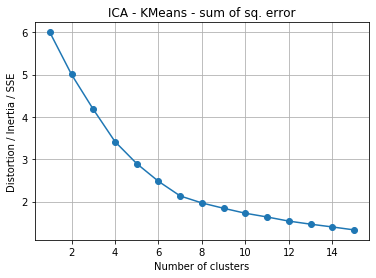

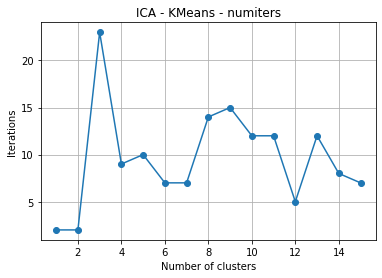

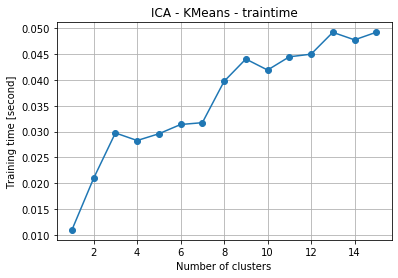

In [13]:
# calculate distortion for a range of number of cluster
distortions = []
numiters = []
traintime = []
nclusters_range = range(1, 16)
for i in nclusters_range:
    km = KMeans(n_clusters=i, 
                random_state=my_random_state)
    
    tic = time.perf_counter() 
    km.fit(x_train_transform)
    toc = time.perf_counter() 
    traintime.append(toc-tic)
    print()
    
    distortions.append(km.inertia_)
    numiters.append(km.n_iter_)

# plot
plt.figure()
plt.plot(nclusters_range, distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion / Inertia / SSE')
plt.title('ICA - KMeans - sum of sq. error')
plt.grid()
plt.savefig('part2/ICA_KMeans_distortion.png')
plt.show()


# plot
plt.figure()
plt.plot(nclusters_range, numiters, marker='o')
plt.title('ICA - KMeans - numiters')
plt.xlabel('Number of clusters')
plt.ylabel('Iterations')
plt.grid()
plt.savefig('part2/ICA_KMeans_numiters.png')
plt.show()


# plot
plt.figure()
plt.plot(nclusters_range, traintime, marker='o')
plt.title('ICA - KMeans - traintime')
plt.xlabel('Number of clusters')
plt.ylabel('Training time [second]')
plt.grid()
plt.savefig('part2/ICA_KMeans_traintime.png')
plt.show()

## n=4

In [14]:
# the best n_clusters determined to be 4 (same as the original labeling)
km4 = KMeans(n_clusters = 4, random_state = my_random_state)


tic = time.perf_counter() 
km4.fit(x_train_transform)
toc = time.perf_counter() 
# train_time[0] = toc-tic
print(f"training time {toc - tic} seconds")
print()

print(km4.cluster_centers_)
print(km4.labels_)
print(km4.inertia_)
print(km4.n_iter_)

training time 0.029952200000479934 seconds

[[-0.04868865 -0.03721332 -0.01751167 -0.01194815 -0.01473424 -0.01761832]
 [ 0.05657343 -0.04300278  0.04089951 -0.01153529  0.04237836  0.04224668]
 [ 0.02066382  0.08251299 -0.00862085 -0.01314494 -0.01288699 -0.01031683]
 [-0.00129326  0.00467521 -0.00041469  0.3470078  -0.00569945  0.00675564]]
[0 0 1 2 2 0 1 0 2 3 0 2 1 1 2 2 0 0 2 0 0 0 0 0 2 0 0 0 0 0 1 2 2 2 3 3 0
 1 1 0 1 1 1 2 2 0 1 0 1 0 0 0 2 2 0 0 2 2 0 0 1 1 2 2 1 0 0 1 1 0 3 0 0 0
 1 2 1 1 0 0 3 0 0 0 0 1 0 1 1 2 0 0 1 0 0 1 2 2 0 0 2 0 2 0 2 0 2 1 0 2 2
 1 0 0 1 2 0 2 1 1 0 2 1 2 0 1 0 2 1 2 1 2 1 0 2 1 2 3 0 2 0 1 0 0 2 2 2 2
 0 2 0 0 0 1 0 0 0 1 2 3 2 1 0 0 2 1 1 0 0 1 0 1 0 1 2 0 2 2 2 1 2 2 0 0 2
 2 1 2 1 0 0 0 0 0 3 0 0 2 2 0 2 1 2 2 0 2 0 2 1 0 1 0 2 2 1 1 2 2 0 0 2 2
 1 2 1 0 2 2 0 0 1 1 2 0 0]
3.4158471099494387
9


[[89  1  0  4]
 [ 4 71  3  4]
 [ 0  0  5 12]
 [ 4  1  0 37]]
Prediction accuracy on train set: 0.8595744680851064


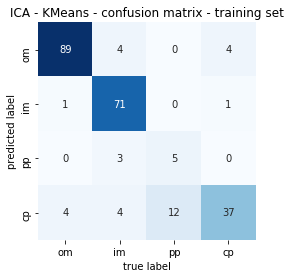

In [15]:
species = ['cp','pp','im','om']
x_train_km4 = []
for l in km4.labels_:
    x_train_km4.append(species[l])


train_confmat_km4 = confusion_matrix(le.inverse_transform(y_train), x_train_km4)
train_accu_km4 = accuracy_score(le.inverse_transform(y_train), x_train_km4)
print(train_confmat_km4)

print(f"Prediction accuracy on train set: {train_accu_km4}")


import seaborn as sns
species.reverse() # for plotting
sns.heatmap(train_confmat_km4.T, cmap=plt.cm.Blues, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=species, yticklabels=species)
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.title('ICA - KMeans - confusion matrix - training set')
plt.savefig('part2/ICA_KMeans_confusion_train.png')


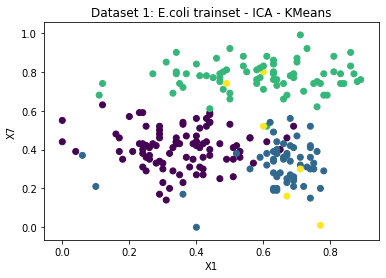

In [17]:
plt.scatter(x_train.X1,x_train.X7, c=km4.labels_, cmap='viridis')
# plt.colorbar();  # show color scale
plt.title('Dataset 1: E.coli trainset - ICA - KMeans')
plt.xlabel('X1')
plt.ylabel('X7')
plt.savefig('part2/ICA_KMeans_scatter_train4.png')
plt.show()

In [18]:
# Evaluate quality of clusters
print('training set')
print('Inertia: ', km4.inertia_)
score = silhouette_score(x_train_transform, km4.labels_)
print('Silhouette score: ', score)
ami = adjusted_mutual_info_score(le.inverse_transform(y_train).reshape(-1), x_train_km4)
print('Adjusted Mutual Information (AMI) score: ', ami)

training set
Inertia:  3.4158471099494387
Silhouette score:  0.2661626902587125
Adjusted Mutual Information (AMI) score:  0.6431065368194259


testing time 0.0005449000000226079 seconds

[[29  6  0 14]
 [ 5 18  1 10]
 [ 0  3  1  4]
 [ 0 10  0  0]]
Prediction accuracy on test set: 0.4752475247524752


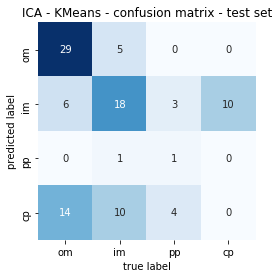

In [19]:


tic = time.perf_counter() 
y_test_predict4 = km4.predict(x_test_transform)
toc = time.perf_counter() 
# test_time[0] = toc-tic
print(f"testing time {toc - tic} seconds")
print()

species = ['om','im','pp','cp']
species = ['cp','pp','im','om']
y_test_km4 = []
for pred in y_test_predict4:
    y_test_km4.append(species[pred])
    
# print(f"Prediction accuracy on test set: {accuracy_score(one_hot.inverse_transform(y_test),y_test_km)}")
# # best_test_accuracy[0] = accuracy_score(y_test,y_test_dt)


test_confmat_km4 = confusion_matrix(le.inverse_transform(y_test), y_test_km4)
test_accu_km4 = accuracy_score(le.inverse_transform(y_test), y_test_km4)
print(test_confmat_km4)
print(f"Prediction accuracy on test set: {test_accu_km4}")


species.reverse() # for plotting
sns.heatmap(test_confmat_km4.T, cmap=plt.cm.Blues, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=species, yticklabels=species)
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.title('ICA - KMeans - confusion matrix - test set')
plt.savefig('part2/ICA_KMeans_confusion_test.png')

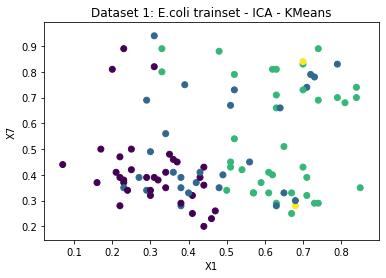

In [21]:
plt.scatter(x_test.X1,x_test.X7, c=y_test_predict4, cmap='viridis')
# plt.colorbar();  # show color scale
plt.title('Dataset 1: E.coli trainset - ICA - KMeans')
plt.xlabel('X1')
plt.ylabel('X7')
plt.savefig('part2/ICA_KMeans_scatter_test4.png')
plt.show()

In [22]:
# Evaluate quality of clusters
print('test set')
score = silhouette_score(x_test_transform, y_test_predict4)
print('Silhouette score: ', score)
ami = adjusted_mutual_info_score(le.inverse_transform(y_test).reshape(-1), y_test_km4)
print('Adjusted Mutual Information (AMI) score: ', ami)

test set
Silhouette score:  0.10684927876454577
Adjusted Mutual Information (AMI) score:  0.20759948054579133


## n=6

In [23]:
# the best n_clusters determined to be 4 (same as the original labeling)
best_n_clusters = 6
km = KMeans(n_clusters = best_n_clusters, random_state = my_random_state)


tic = time.perf_counter() 
km.fit(x_train_transform)
toc = time.perf_counter() 
# train_time[0] = toc-tic
print(f"training time {toc - tic} seconds")
print()

print(km.cluster_centers_)
print(km.labels_)
print(km.inertia_)
print(km.n_iter_)

training time 0.03429110000070068 seconds

[[-0.04867956 -0.03894774 -0.02245866 -0.01193041 -0.01368001 -0.01648122]
 [ 0.06118898 -0.05605122  0.07842398 -0.01134342 -0.00151801 -0.01073095]
 [ 0.02092028  0.08172135 -0.01073043 -0.01310359 -0.01115916 -0.01046734]
 [-0.00129326  0.00467521 -0.00041469  0.3470078  -0.00569945  0.00675564]
 [ 0.04586344 -0.02627066 -0.0026901  -0.01409319  0.01405355  0.16131605]
 [-0.00475794  0.01993939  0.00276263 -0.00724024  0.2785302  -0.01464345]]
[0 0 1 2 2 0 1 0 2 3 0 2 1 2 2 2 0 0 2 0 0 0 0 0 2 0 0 0 0 0 4 2 1 2 3 3 0
 1 4 1 1 1 5 2 2 0 4 5 1 0 0 0 2 2 0 0 2 2 0 0 1 5 2 2 1 1 0 4 4 0 3 0 0 0
 1 2 4 1 0 0 3 0 0 0 0 1 0 0 1 2 0 0 1 0 0 1 2 2 0 1 2 0 2 4 2 0 2 1 0 2 2
 1 0 0 4 2 0 2 1 1 0 2 1 2 0 4 0 2 1 2 4 2 4 0 2 0 2 3 0 2 0 1 0 0 2 2 2 2
 0 2 1 0 0 5 0 0 0 4 2 3 2 5 0 0 2 1 4 0 0 4 0 1 0 1 2 0 2 2 2 1 2 2 0 0 2
 2 1 2 4 0 0 0 0 0 3 0 0 2 2 0 2 1 2 2 0 2 0 2 1 0 4 0 2 2 1 1 2 2 0 0 2 2
 5 2 4 0 2 2 0 0 1 5 2 0 0]
2.4780053936314106
7


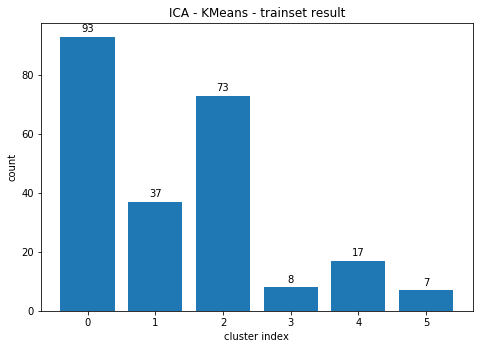

In [24]:
clusterindices = [str(e) for e in range(best_n_clusters)]
counts = np.zeros(best_n_clusters)
for p in km.labels_:
    counts[p] += 1

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
rects = ax.bar(clusterindices, counts)
plt.title('ICA - KMeans - trainset result')
plt.xlabel('cluster index')
plt.ylabel('count')
plt.savefig('part2/ICA_Kmeans_train.png')

def autolabel2(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:0.0f}'.format(height),
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel2(rects)

plt.show()


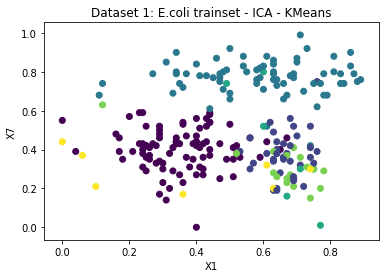

In [25]:
plt.scatter(x_train.X1,x_train.X7, c=km.labels_, cmap='viridis')
# plt.colorbar();  # show color scale
plt.title('Dataset 1: E.coli trainset - ICA - KMeans')
plt.xlabel('X1')
plt.ylabel('X7')
plt.savefig('part2/ICA_KMeans_scatter_train.png')
plt.show()

In [27]:
# Evaluate quality of clusters
print('training set')
print('Inertia: ', km.inertia_)
score = silhouette_score(x_train_transform, km.labels_)
print('Silhouette score: ', score)
# ami = adjusted_mutual_info_score(one_hot.inverse_transform(y_train).reshape(-1), x_train_km)
ami = adjusted_mutual_info_score(le.inverse_transform(y_train).reshape(-1), km.labels_)
print('Adjusted Mutual Information (AMI) score: ', ami)

training set
Inertia:  2.4780053936314106
Silhouette score:  0.3116638583097153
Adjusted Mutual Information (AMI) score:  0.6650076464879467


In [33]:


tic = time.perf_counter() 
y_test_predict = km.predict(x_test_transform)
toc = time.perf_counter() 
# test_time[0] = toc-tic
print(f"testing time {toc - tic} seconds")
print()

y_test_predict

testing time 0.0006096999986766605 seconds



array([2, 2, 2, 1, 1, 1, 2, 2, 2, 4, 4, 2, 2, 0, 0, 2, 1, 2, 2, 0, 0, 0,
       0, 2, 2, 1, 1, 4, 0, 4, 1, 1, 0, 1, 1, 2, 2, 4, 2, 1, 2, 1, 1, 0,
       2, 4, 0, 0, 0, 2, 1, 5, 1, 0, 1, 4, 0, 2, 2, 2, 0, 3, 4, 2, 0, 2,
       1, 0, 0, 4, 2, 4, 0, 0, 0, 4, 0, 4, 0, 0, 2, 0, 2, 1, 0, 3, 4, 2,
       0, 0, 0, 2, 4, 2, 4, 4, 0, 2, 2, 2, 0])

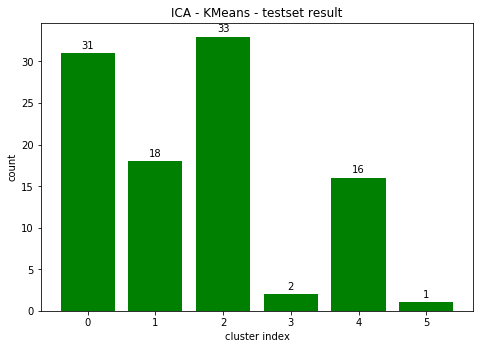

In [34]:
clusterindices = [str(e) for e in range(best_n_clusters)]
counts = np.zeros(best_n_clusters)
for p in y_test_predict:
    counts[p] += 1

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
rects = ax.bar(clusterindices, counts, color = 'green')
plt.title('ICA - KMeans - testset result')
plt.xlabel('cluster index')
plt.ylabel('count')
plt.savefig('part2/ICA_Kmeans_test.png')
def autolabel2(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:0.0f}'.format(height),
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel2(rects)

plt.show()


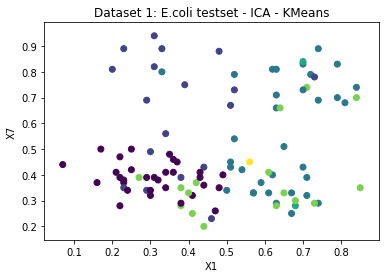

In [35]:
plt.scatter(x_test.X1,x_test.X7, c=y_test_predict, cmap='viridis')
# plt.colorbar();  # show color scale
plt.title('Dataset 1: E.coli testset - ICA - KMeans')
plt.xlabel('X1')
plt.ylabel('X7')
plt.savefig('part2/ICA_KMeans_scatter_test.png')
plt.show()

In [36]:
# Evaluate quality of clusters
print('test set')
# test_accu_km = accuracy_score(one_hot.inverse_transform(y_test), y_test_gm)
# print(f"Prediction accuracy on test set: {test_accu_gm}")
score = silhouette_score(x_test_transform, y_test_predict)
print('Silhouette score: ', score)
ami = adjusted_mutual_info_score(le.inverse_transform(y_test).reshape(-1), y_test_predict)
print('Adjusted Mutual Information (AMI) score: ', ami)

test set
Silhouette score:  0.10707961548712511
Adjusted Mutual Information (AMI) score:  0.28936029361876714


# 2.1.1. after dimensional reduction: Expectation Maximization (EM)

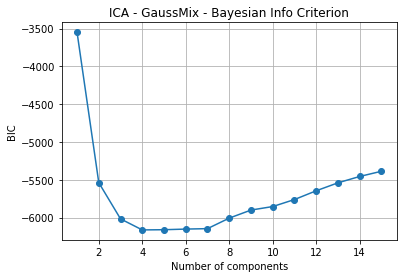

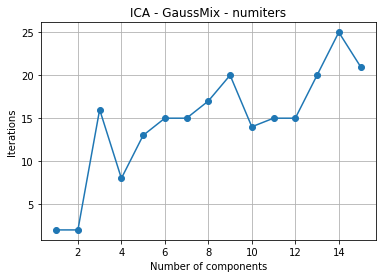

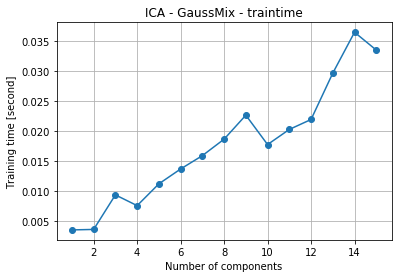

In [37]:
# Find the optimal number of components using BIC
n_components_grid = np.arange(1, 16)
# bic = np.zeros(n_components_grid.size)
bic = []
numiters = []
traintime = []

# for idx, n_components in enumerate(n_components_grid):
for n_components in n_components_grid:
    gm = GaussianMixture(n_components=n_components, random_state=my_random_state)
    
    tic = time.perf_counter() 
    gm.fit(x_train_transform)
    toc = time.perf_counter() 
    traintime.append(toc-tic)
    
    numiters.append(gm.n_iter_)
    bic.append(gm.bic(x_train_transform))
#     bic[idx] = gm.bic(x_train)
print()


# Plot BIC vs number of components
plt.figure()
plt.plot(n_components_grid, bic, marker='o')
# plt.xticks(k_grid)
plt.title('ICA - GaussMix - Bayesian Info Criterion')
plt.xlabel('Number of components')
plt.ylabel('BIC')
plt.grid()
plt.savefig('part2/ICA_gm_bic.png')

# plot
plt.figure()
plt.plot(n_components_grid, numiters, marker='o')
plt.title('ICA - GaussMix - numiters')
plt.xlabel('Number of components')
plt.ylabel('Iterations')
plt.grid()
plt.savefig('part2/ICA_gm_numiters.png')
plt.show()


# plot
plt.figure()
plt.plot(n_components_grid, traintime, marker='o')
plt.title('ICA - GaussMix - traintime')
plt.xlabel('Number of components')
plt.ylabel('Training time [second]')
plt.grid()
plt.savefig('part2/ICA_gm_traintime.png')
plt.show()

## best_n_component = 4

In [38]:
# the best n_clusters determined to be 4 (same as the original labeling)
best_n_component = 4
gm4 = GaussianMixture(n_components=best_n_component, random_state=my_random_state)


tic = time.perf_counter() 
gm4.fit(x_train_transform)
toc = time.perf_counter() 

print(f"training time {toc - tic} seconds")
print()

y_train_predict4 = gm4.predict(x_train_transform)
y_train_predict4

training time 0.008595800001785392 seconds



array([0, 0, 1, 2, 2, 0, 1, 0, 2, 3, 0, 2, 1, 1, 2, 0, 0, 1, 2, 0, 0, 0,
       1, 0, 2, 0, 0, 0, 0, 0, 1, 2, 2, 2, 3, 3, 0, 1, 1, 0, 1, 1, 1, 2,
       2, 0, 1, 1, 1, 0, 0, 1, 2, 2, 0, 0, 2, 2, 0, 0, 1, 1, 2, 1, 1, 1,
       0, 1, 1, 0, 3, 0, 0, 0, 1, 2, 1, 1, 0, 1, 3, 0, 0, 0, 0, 1, 0, 1,
       1, 2, 0, 0, 1, 0, 0, 1, 2, 2, 1, 0, 2, 0, 2, 2, 2, 0, 2, 1, 0, 2,
       2, 1, 0, 1, 1, 2, 0, 2, 1, 1, 0, 2, 1, 2, 0, 1, 0, 2, 1, 2, 1, 2,
       1, 0, 2, 1, 2, 3, 0, 2, 0, 1, 0, 0, 2, 2, 2, 2, 0, 2, 1, 0, 0, 1,
       0, 0, 0, 1, 2, 3, 2, 1, 0, 0, 2, 1, 1, 0, 0, 1, 0, 1, 0, 1, 2, 0,
       2, 2, 2, 1, 2, 2, 0, 1, 2, 2, 1, 2, 1, 0, 0, 0, 0, 0, 3, 0, 0, 2,
       2, 1, 2, 1, 0, 2, 0, 2, 0, 2, 1, 0, 1, 0, 2, 2, 1, 1, 2, 2, 0, 0,
       2, 2, 1, 2, 1, 0, 2, 2, 1, 0, 1, 1, 2, 1, 0], dtype=int64)

[[78  0  0 16]
 [ 3 70  3  6]
 [ 0  0  5 12]
 [ 4  1  0 37]]
Prediction accuracy on train set: 0.8085106382978723


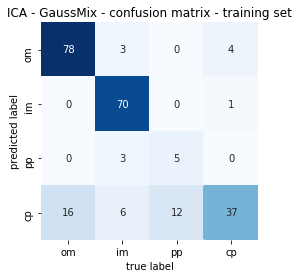

In [40]:
species = ['cp','pp','im','om']
# species = ['pp','om','im','cp']
y_train_gm4 = []
for l in y_train_predict4:
    y_train_gm4.append(species[l])


# train_confmat_gm4 = confusion_matrix(one_hot.inverse_transform(y_train).reshape(-1), np.array(x_train_gm4).reshape(-1))
train_confmat_gm4 = confusion_matrix(le.inverse_transform(y_train), y_train_gm4)
train_accu_gm4 = accuracy_score(le.inverse_transform(y_train), y_train_gm4)
print(train_confmat_gm4)

print(f"Prediction accuracy on train set: {train_accu_gm4}")

species.reverse() # for plotting
sns.heatmap(train_confmat_gm4.T, cmap=plt.cm.Blues, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=species, yticklabels=species)
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.title('ICA - GaussMix - confusion matrix - training set')
plt.savefig('part2/ICA_gm_confusion_train.png')


In [41]:
# Evaluate quality of clusters
print('training set')
# print('Inertia: ', km4.inertia_)
score = silhouette_score(x_train_transform, y_train_predict4)
print('Silhouette score: ', score)
ami = adjusted_mutual_info_score(le.inverse_transform(y_train).reshape(-1), y_train_predict4)
print('Adjusted Mutual Information (AMI) score: ', ami)

training set
Silhouette score:  0.22891628815832685
Adjusted Mutual Information (AMI) score:  0.57171294118829


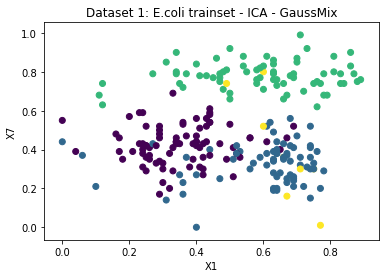

In [42]:
plt.scatter(x_train.X1,x_train.X7, c=y_train_predict4, cmap='viridis')
# plt.colorbar();  # show color scale
plt.title('Dataset 1: E.coli trainset - ICA - GaussMix')
plt.xlabel('X1')
plt.ylabel('X7')
plt.savefig('part2/ICA_gm_scatter_train4.png')
plt.show()

In [43]:

tic = time.perf_counter() 
y_test_predict4 = gm4.predict(x_test_transform)
toc = time.perf_counter() 
# test_time[0] = toc-tic
print(f"testing time {toc - tic} seconds")
print()

y_test_predict4

testing time 0.000908500000150525 seconds



array([1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 0, 2, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 0, 2, 2, 1, 1, 3, 1, 2, 1, 2,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 3, 1, 2,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1], dtype=int64)

[[ 5  6  0 38]
 [ 0  6  1 27]
 [ 0  1  1  6]
 [ 0  6  0  4]]
Prediction accuracy on test set: 0.15841584158415842


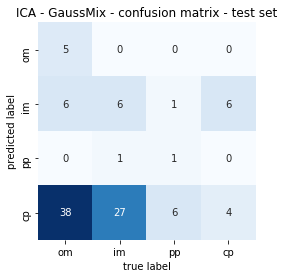

In [44]:


species = ['cp','pp','im','om']
y_test_gm4 = []
for pred in y_test_predict4:
    y_test_gm4.append(species[pred])
    
# print(f"Prediction accuracy on test set: {accuracy_score(one_hot.inverse_transform(y_test),y_test_km)}")
# # best_test_accuracy[0] = accuracy_score(y_test,y_test_dt)


test_confmat_gm4 = confusion_matrix(le.inverse_transform(y_test), y_test_gm4)
test_accu_gm4 = accuracy_score(le.inverse_transform(y_test), y_test_gm4)
print(test_confmat_gm4)
print(f"Prediction accuracy on test set: {test_accu_gm4}")


species.reverse() # for plotting
sns.heatmap(test_confmat_gm4.T, cmap=plt.cm.Blues, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=species, yticklabels=species)
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.title('ICA - GaussMix - confusion matrix - test set')
plt.savefig('part2/ICA_gm_confusion_test.png')

In [46]:
# Evaluate quality of clusters
print('test set')
# test_accu_km = accuracy_score(one_hot.inverse_transform(y_test), y_test_gm)
# print(f"Prediction accuracy on test set: {test_accu_gm}")
score = silhouette_score(x_test_transform, y_test_predict4)
print('Silhouette score: ', score)
ami = adjusted_mutual_info_score(le.inverse_transform(y_test).reshape(-1), y_test_predict4)
print('Adjusted Mutual Information (AMI) score: ', ami)

test set
Silhouette score:  -0.1323272916316859
Adjusted Mutual Information (AMI) score:  0.062297389946908116


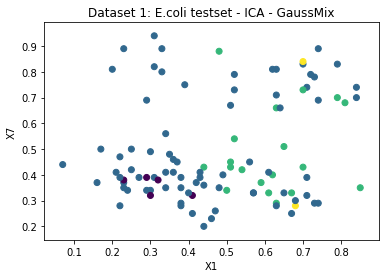

In [47]:
plt.scatter(x_test.X1,x_test.X7, c=y_test_predict4, cmap='viridis')
# plt.colorbar();  # show color scale
plt.title('Dataset 1: E.coli testset - ICA - GaussMix')
plt.xlabel('X1')
plt.ylabel('X7')
plt.savefig('part2/ICA_gm_scatter_test4.png')
plt.show()

# best_n_component = 6 still bad

In [48]:
# 3 is determined to be the best number of components
best_n_component = 6
gm = GaussianMixture(n_components=best_n_component, random_state=my_random_state)


tic = time.perf_counter() 
gm.fit(x_train_transform)
toc = time.perf_counter() 

print(f"training time {toc - tic} seconds")
print()

y_train_predict = gm.predict(x_train_transform)
y_train_predict

training time 0.014967799999794806 seconds



array([0, 0, 4, 5, 2, 0, 4, 0, 2, 3, 0, 2, 4, 5, 2, 2, 0, 5, 2, 0, 0, 0,
       4, 0, 2, 0, 0, 0, 0, 0, 1, 2, 2, 2, 3, 3, 0, 4, 1, 0, 4, 4, 5, 5,
       2, 0, 1, 5, 5, 0, 0, 4, 2, 2, 0, 0, 2, 2, 0, 0, 4, 5, 2, 5, 4, 4,
       0, 1, 1, 0, 3, 0, 0, 0, 4, 2, 1, 4, 0, 4, 3, 0, 0, 0, 0, 4, 0, 5,
       4, 2, 0, 0, 4, 0, 0, 4, 2, 2, 5, 0, 2, 0, 5, 2, 2, 0, 2, 4, 0, 5,
       2, 4, 0, 4, 1, 2, 0, 2, 4, 4, 0, 5, 4, 2, 0, 1, 0, 5, 4, 2, 4, 5,
       1, 0, 2, 4, 2, 3, 0, 2, 0, 4, 0, 0, 2, 2, 2, 2, 0, 5, 4, 0, 0, 1,
       0, 0, 0, 4, 2, 3, 2, 5, 0, 0, 2, 4, 4, 0, 0, 4, 0, 4, 0, 4, 5, 0,
       2, 2, 2, 4, 2, 2, 0, 4, 2, 2, 4, 2, 4, 0, 0, 0, 0, 0, 3, 0, 0, 2,
       2, 4, 2, 4, 0, 2, 0, 2, 0, 5, 4, 0, 1, 0, 2, 2, 4, 4, 2, 2, 0, 0,
       2, 2, 1, 2, 1, 0, 5, 2, 5, 0, 4, 1, 2, 5, 0], dtype=int64)

In [49]:
# Evaluate quality of clusters
print('training set')
score = silhouette_score(x_train_transform, y_train_predict)
print('Silhouette score: ', score)
ami = adjusted_mutual_info_score(le.inverse_transform(y_train).reshape(-1), y_train_predict)
print('Adjusted Mutual Information (AMI) score: ', ami)
# print(f"Prediction accuracy on train set: {accuracy_score(one_hot.inverse_transform(y_train),y_train_predict)}")

training set
Silhouette score:  0.22847397247219173
Adjusted Mutual Information (AMI) score:  0.5780959772092538


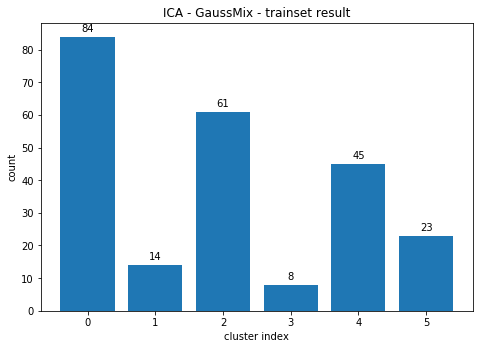

In [50]:
clusterindices = [str(e) for e in range(best_n_component)]
counts = np.zeros(best_n_component)
for yp in y_train_predict:
    counts[yp] += 1

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
rects = ax.bar(clusterindices,counts)

def autolabel2(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:0.0f}'.format(height),
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel2(rects)

plt.title('ICA - GaussMix - trainset result')
plt.xlabel('cluster index')
plt.ylabel('count')
plt.savefig('part2/ICA_gm_train.png')
plt.show()

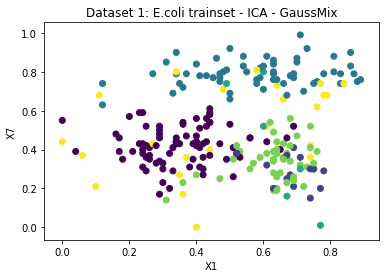

In [51]:
plt.scatter(x_train.X1,x_train.X7, c=y_train_predict, cmap='viridis')
# plt.colorbar();  # show color scale
plt.title('Dataset 1: E.coli trainset - ICA - GaussMix')
plt.xlabel('X1')
plt.ylabel('X7')
plt.savefig('part2/ICA_gm_scatter_train.png')
plt.show()

In [52]:


tic = time.perf_counter() 
y_test_predict = gm.predict(x_test_transform)
toc = time.perf_counter() 
# test_time[0] = toc-tic
print(f"testing time {toc - tic} seconds")
print()

x_test_predict

testing time 0.0004631000010704156 seconds



NameError: name 'x_test_predict' is not defined

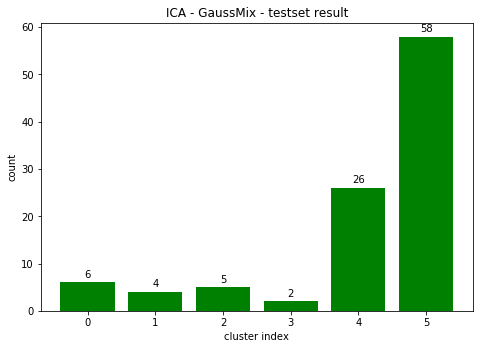

In [53]:
clusterindices = [str(e) for e in range(best_n_component)]
counts = np.zeros(best_n_component)
for p in y_test_predict:
    counts[p] += 1

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
rects = ax.bar(clusterindices, counts, color = 'green')
plt.title('ICA - GaussMix - testset result')
plt.xlabel('cluster index')
plt.ylabel('count')
plt.savefig('part2/ICA_gm_test.png')
def autolabel2(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:0.0f}'.format(height),
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel2(rects)

plt.show()


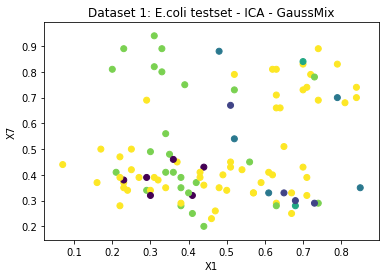

In [54]:
plt.scatter(x_test.X1,x_test.X7, c=y_test_predict, cmap='viridis')
# plt.colorbar();  # show color scale
plt.title('Dataset 1: E.coli testset - ICA - GaussMix')
plt.xlabel('X1')
plt.ylabel('X7')
plt.savefig('part2/ICA_gm_scatter_test.png')
plt.show()

In [55]:
# Evaluate quality of clusters
print('test set')
# test_accu_km = accuracy_score(one_hot.inverse_transform(y_test), y_test_gm)
# print(f"Prediction accuracy on test set: {test_accu_gm}")
score = silhouette_score(x_test_transform, y_test_predict)
print('Silhouette score: ', score)
ami = adjusted_mutual_info_score(le.inverse_transform(y_test).reshape(-1), y_test_predict)
print('Adjusted Mutual Information (AMI) score: ', ami)

test set
Silhouette score:  -0.13116447403814305
Adjusted Mutual Information (AMI) score:  0.1407287131893208


# 没用的

In [ ]:
species = ['om','pp','im','cp']
y_train_gm = []
for l in y_train_predict:
    y_train_gm.append(species[l])


train_confmat_gm = confusion_matrix(one_hot.inverse_transform(y_train), y_train_gm)
train_accu_gm = accuracy_score(one_hot.inverse_transform(y_train), y_train_gm)
print(train_confmat_gm)

print(f"Prediction accuracy on train set: {train_accu_gm}")


species.reverse() # for plotting
sns.heatmap(train_confmat_gm.T, cmap=plt.cm.Blues, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=species, yticklabels=species)
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.title('initial clustering - GaussMix - confusion matrix - training set')
plt.savefig('part1/initial_gm_confusion_train.png')


In [ ]:

# plot
plt.figure()
plt.hist(y_train_predict, bins = best_n_component)
plt.title('initial clustering - GaussMix - result')
plt.xlabel('cluster #')
plt.ylabel('count')
# plt.grid()
plt.savefig('part1/initial_gm_result.png')
plt.show()



In [ ]:

plt.figure()
plt.hist(km3.labels_, bins=np.arange(0, best_n_clusters + 1) - 0.5, rwidth=0.5, zorder=2)
plt.xticks(np.arange(0, best_n_clusters))
plt.xlabel('Cluster label')
plt.ylabel('Number of samples')
plt.grid()
plt.title('PCA - KMeans - train set')
plt.savefig('part2/PCA_Kmeans_train.png')